# Recurrent Neural Networks for Text Generation

With the [exception of RBMs](./rbm.ipynb), we have so far mainly witnessed the power of deep nets in the context of [supervised learning](./sgd.ipynb). In other words, given a certain amount of data, we used deep nets to predict the price of a house or the type of a flower. In the present notebook, we see that deep nets can also generate data -- such as Nietzsche literature! The analysis of language using AI is also known as **natural language processing (NLP)**.

However, before diving into the generation task, we need to talk about new architecture for dealing with sequence data: **recurrent neural networks (RNNs)**.

## Recurrent Neural Networks

In order to represent text as data, we have several options such as encoding single characters or words, or even groups of words - called *n-grams*. However, none of these representations is nicely compatible with MLPs. 

Indeed, first MLPs expect a fixed-length input, whereas sentences can arguably be of very different length, as the following quotes illustrate:

Barack Obama

> Yes, we can

Immanuel Kant

> Ist
dieses nun nicht geschehen, und kann es auch, wegen der Untauglichkeit
des gemeinen Menschenverstandes zu so subtiler Spekulation, niemals
erwartet werden; hat vielmehr, was das erstere betrifft, die jedem
Menschen bemerkliche Anlage seiner Natur, durch das Zeitliche (als
zu den Anlagen seiner ganzen Bestimmung unzulänglich) nie zufrieden
gestellt werden zu können, die Hoffnung eines künftigen Lebens, in
Ansehung des zweiten die bloße klare Darstellung der Pflichten im
Gegensatze aller Ansprüche der Neigungen das Bewußtsein der Freiheit,
und endlich, was das dritte anlangt, die herrliche Ordnung, Schönheit
und Fürsorge, die allerwärts in der Natur hervorblickt, allein den
Glauben an einen weisen und großen Welturheber, die sich aufs Publikum
verbreitende Überzeugung, sofern sie auf Vernunftgründen beruht,
ganz allein bewirken müssen: so bleibt ja nicht allein dieser Besitz
ungestört, sondern er gewinnt vielmehr dadurch noch an Ansehen,
daß die Schulen nunmehr belehrt werden, sich keine höhere und
ausgebreitetere Einsicht in einem Punkte anzumaßen, der die allgemeine
menschliche Angelegenheit betrifft, als diejenige ist, zu der die
große (für uns achtungswürdigste) Menge auch eben so leicht gelangen
kann, und sich also auf die Kultur dieser allgemein faßlichen und in
moralischer Absicht hinreichenden Beweisgründe allein einzuschränken.

In addition, in text the appearance of one character or word typically has a strong influence on the following ones. This is also reflected poorly in MLPs.

Having these insufficies of MLPs in mind lead to the development of **recurrent neural networks (RNNs)** as illustrated below in a [wonderful blogpost by Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) 


<img src="images/rnn.png" alt="Drawing" style="width: 500px;"/>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In the figure above, the variables $x_i$ denote sequential input such as characters or words. The symbol $A$ represents a network combining the information of the current input together with a previous output in order to obtain more refined view. The value $h_i$ can be an output of any kind, such as for instance a prediction for the most probable following character.

The training mechanism of RNNs is known as *backpropagation through time* and some authors feel the urge to introduce the abbreviation *BPTT*. Essentially, BPTT means considering the RNN as a feed-forward neural network and applying the standard backpropagation, as we encountered it in a [previous notebook](./sgd.html).

The only caveat is that each weight appears once in each layer and typically the gradient signals in different layers do not agree. Hence, what is done in BPTT is to update the weights by the sum of the gradients from each of the layers.

### Long Short-Term Memory Networks

Although RNNs do manage to capture sequential dependencies, they are myopic in the sense that incorporating information of more than two or three steps in the past remains very difficult. However, when analyzing language data it is quite common to see dependencies spanning over the entire sentence. Let me just mention that Germans love to put verbs at the end of a sentence!

The reason behind this limitation is known as **vanishing gradient problem**. That is, if information should be taken into account over long ranges in the sentence, then in the backpropagation mechanism the gradient signal needs to travel over many steps and therefore becomes very weak. To combat the vanishing gradient problem, in 1997 [Sepp Hochreiter and Jürgen Schmidhuber](https://www.ncbi.nlm.nih.gov/pubmed/9377276) developed the **long short-term memory (LSTM) networks**.

The principal idea behind LSTM networks is the introduction of gates allowing gradients to travel across many layers without diminishing their strength after every step. Here is another beautiful illustration from [Christopher Olah's blogpost](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

<img src="images/lstm.png" alt="Drawing" style="width: 500px;"/>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In ``Keras`` LSTMs are available as a layer.

In [11]:
from keras import models,layers

cell_size = 32

model = models.Sequential([
    layers.LSTM(cell_size, input_shape=(None, 64)),
    layers.Dense(1)
])

In order to understand the concept of gates, let's take a closer look at the defining equations of the LSTM. The central architectural unit of an LSTM is a *cell* storing information stemming from possibly distant relevant parts of the input. At time step $t$ the cell state $C_t \in \mathbb{R}^h$ is a linear combination of the cell state $C_{t-1}$ in the previous step and an **update vector** $\tilde{C}_{t-1}$:
$$C_t = f_t \cdot C_{t-1} +  i_t \cdot \tilde{C}_{t}$$

Here, the coefficients $f_t, i_t \in [0,1]^h$ and the update vector $\tilde{C}_{t} \in [-1,1]^h$ are determined as follows. The coefficient $f_{t}$ is called **forget gate** and determines how much of the information from the previous cell should be retained. It is computed via a single-layer MLP with sigmoid-activation from the current input $x_t$ and the output $h_{t-1}$ from the previous step:
$$f_t = \sigma(W_{{\mathsf{f}}}[x_t; h_{t-1}] + b_{\mathsf{f}})$$

Similarly, the **input gate** $i_t$ determines how much of the update vector is incorporated in the $t$th step:
$$i_t = \sigma(W_{{\mathsf{i}}}[x_t; h_{t-1}] + b_{\mathsf{i}})$$

The update vector $\tilde{C}_{t}$ is also obtained as a single-layer MLP, but using a $\tanh$-activation instead:
$$\tilde{C}_t = \tanh(W_{{\mathsf{C}}}[x_t; h_{t-1}] + b_{\mathsf{C}})$$

The final step in the LSTM cell is to relate the output $h_t$ to the current cell state $C_t$:
$$h_t = o_t \cdot \tanh(C_t),$$
with the **output gate** 
$$o_t = \sigma(W_{{\mathsf{o}}}[x_t; h_{t-1}] + b_{\mathsf{o}}).$$

### Temperature Data

Before letting LSTMs speak Nietzsche, we explore how useful LSTM are when working with standard numerical time series. Here, we follow [François Chollets notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb) on the analysis of German weather data: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

#### Data Preprocessing

First, we load the data and set the time as index.

In [4]:
import pandas as pd
import seaborn; seaborn.set()
%matplotlib inline

temp_df = pd.read_csv('./data/jena.csv')
temp_df = temp_df.set_index('Date Time')

We convert the index into datetime type.  We also reduce the time-granularity and only consider hourly data.

In [5]:
step = '1H'

temp_df.index = pd.to_datetime(temp_df.index)
temp_df = temp_df.resample('1H').first().fillna(0)

We plot the temperature over the years.

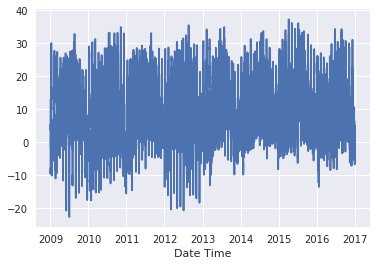

In [150]:
temp_df.iloc[::,1].plot()

When using neural networks with numeric data, it is crucial to standardize the input first. 

In [6]:
from sklearn import preprocessing

np_scaled =  preprocessing.StandardScaler().fit_transform(temp_df)
norm_df = pd.DataFrame(np_scaled, columns = temp_df.columns, index = temp_df.index)

####  Model Architecture

 As architecture, we choose an LSTM unit with cellsize 32 and optimize it with respect to mean average error

In [32]:
from keras import optimizers

cell_size = 32
lr = 1e-3

model = models.Sequential([
    layers.LSTM(cell_size, input_shape=(None, norm_df.shape[-1])),
    layers.Dense(1)
])

model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')

#### Training

In order to feed the network with training data, we need to break it up into chunks of a manageable size.

For that purpose, we use a generator adapted from [François Chollets notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb) in order to split the data into smaller pieces.

In [33]:
import numpy as np

def generator(df, start, end, lookback=5, delay=1, batch_size=128):
    while True:
        full_range = pd.date_range(start, end, freq='1h', closed='left')
        
        #choose a random mini-batch
        batch_dates = full_range[np.random.randint(0, len(full_range), batch_size)]
        
        #prediction based on past data
        samples = [df.loc[pd.date_range(date - pd.DateOffset(days=lookback), date, freq='1h', closed='right')]
            for date in batch_dates]
        
        #prediction into the future
        targets = [df.iloc[:,1].loc[date + pd.DateOffset(days=delay)]
            for date in batch_dates]
                            
        yield [np.stack(st) for st in [samples, targets]]

Now, we define generators for training, validation and test data.

In [34]:
train_gen = generator(norm_df, '2010', '2015')
val_gen = generator(norm_df, '2015', '2016')
test_gen = generator(norm_df, '2016', '2017')

Now, we perform the actual training. Already after a small number of epochs, the validation loss stabilizes.

In [35]:
steps_per_epoch=200
epochs = 1
validation_steps=50

model.fit_generator(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=validation_steps)

Epoch 1/1
200/200 [==============================] - 35s 175ms/step - loss: 0.4923 - val_loss: 0.4818


Before moving to the language domain, we note that the above architecture only provides the most basic approach towards applying RNNs for time series data. In particular, recurrent neural networks nowadays outperform traditional time-series techniques such as *ARIMA* if one resorts to a *seq2seq* architecture. [Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) gives a beautiful explanation of these ideas together with a variety of impressive illustrations.

## Text Generation

After having gained experience on how LSTMs are used for numerical sequence data, we can now venture into the domain of NLP. Here, we follow in large parts [Chapter 8.1 of *Deep Learning with Python*](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.1-text-generation-with-lstm.ipynb). So, how can we get RNNs to generate text for us?

The basic idea is simple. We consider text as a sequence of suitably encoded characters and then train an RNN for predicting the most probable next character. We explore the strengths and weaknesses of this method by generating text from Nietzsche.

#### Data Preprocessing

First, we load the text and one-hot encode the characters.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder( sparse = False)


text = open('./data/nietzsche.txt').read().lower()
text_ohe = ohe.fit_transform(le.fit_transform(list(text)).reshape(-1,1))
nchars = ohe.n_values_[0]

Next, we split it into shorter sequences. For each of these sequences, we also keep the following character.

In [2]:
maxlen = 60
step = 3
train_size = len(range(0, len(text) - maxlen, step))


sentences = np.zeros((train_size, maxlen, text_ohe.shape[1]))
next_chars =  np.zeros((train_size,text_ohe.shape[1]))

for i in range(0, len(text) - maxlen, step):
    sentences[int(i/step),:,:] = text_ohe[i: i + maxlen,:]
    next_chars[int(i/step),:] = text_ohe[i + maxlen,:]

#### Model Architecture

As architecture, we choose a single-layer LSTM optimized with respect to cross-entropy.

In [4]:
from tensorflow import keras
from keras import layers, models, optimizers

cell_size = 128
lr = 1e-2

model = models.Sequential([
    layers.LSTM(cell_size,  input_shape=(maxlen, nchars)),
    layers.Dense(ohe.n_values_[0], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr))

Now, we train the model.

In [44]:
batch_size = 128
epochs = 1

model.fit(sentences, next_chars, batch_size=batch_size, epochs=epochs)

Epoch 1/1
200278/200278 [==============================] - 224s 1ms/step - loss: 1.5519


Note that the last layer of the model is a softmax layer over the characters. In order to use the model for text-generation, we need to convert these probabilities into actual characters. 

For this purpose, we take from [François Chollets notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.1-text-generation-with-lstm.ipynb) a sampling function of characters depending on the activations in the final layer. This sampling function depends on a temperature parameter interpolating between a uniform distribution and a delta distribution on the most likely character.

In [36]:
EPS = 1e-5

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    logits = np.log(preds + EPS) / temperature
 
    softmax = np.exp(logits) / np.sum(np.exp(logits))
    sample = np.random.multinomial(1, softmax) 
    return np.argmax(sample)

In [82]:
from numpy import random
import sys 

seed=42
temperature = .6
gen_text_len = 400
#random.seed(seed)

start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]
print(generated_text)

generated_text = ohe.transform(le.transform(list(generated_text)).reshape(-1,1))
generated_text = np.expand_dims(generated_text, 0)

for i in range(gen_text_len):

        preds = model.predict(generated_text, verbose=0)[0]
        next_index = sample(preds, temperature)

        #print char
        sys.stdout.write(le.classes_[next_index])
        sys.stdout.flush()

        #update text
        new_text = np.concatenate([generated_text[:, 1:, :], 
                                   np.expand_dims(ohe.transform(next_index),0)], 
                                  axis=1)
        generated_text = new_text

 for what must these
clumsy attempts of feminine scientifica
ristic and
the become the believe the deption of the solest and real so far of believe all often anying altering to course of the securing more soul of here and surplistion as and for the species also confeduents of man enextence, and the brensting of our every delight and not stranger and whish man his sublight, it feel of a primiled to man appaint of man class" of submly and by greatest soul whi

We see that RNNs can make steps into imitating Nietzsche! However, a closer look reveals that this approach produces examples that stick rather closely to the original text. Developing different generative models not suffering so strongly  from this problem is an active area of research in AI.

After more training, the sentences would become even better. Here are examples from [Andrej Karpathy's blogpost](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) trained on Shakespeare.

>  VIOLA:
Why, Salisbury must find his flesh and thought
That which I am not aps, not a man and in fire,
To show the reining of the raven and the wars
To grace my hand reproach within, and not a fair are hand,
That Caesar and my goodly father's world;
When I was heaven of presence and our fleets,
We spare with hours, but cut thy council I am great,
Murdered and by thy master's ready there
My power to give thee but so much as hell:
Some service in the noble bondman here,
Would show him to her wine.

>KING LEAR:
O, if you were a feeble sight, the courtesy of your law,
Your sight and several breath, will wear the gods
With his heads, and my hands are wonder'd at the deeds,
So drop upon your lordship's head, and your opinion
Shall be against your honour.

## Homework

Implement the prediction based on the seq2seq model and improve the predictions above!

Create a LSTM model based on word encoding.